# Predict CO₂ levels with out-of-time validation modeling

This notebook demonstrates how to use [out-of-time validation (OTV)](https://docs.datarobot.com/en/docs/modeling/special-workflows/otv.html) modeling with DataRobot's Python client to predict monthly CO₂ levels for one of Hawaii's active volcanoes, Mauna Loa. The dataset used in this notebook can be accessed [here](https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html) (select the first dataset listed to emulate results displayed below), but DataRobot provides a ready-to-use version of this dataset below. For this notebook, the target feature is `interpolated` because `average` has a some missing values that should be skipped.

OTV is a useful modeling method when you know that your data changes in distribution over time. If this is true of your data, random sampling of training and testing datasets would not yield an outcome that would be representative of the model accuracy when it is making predictions in a production environment. Note that OTV can be applied to both classification and regression projects. It partitions your data using the [backtesting](https://docs.datarobot.com/en/docs/modeling/special-workflows/otv.html#backtests) method, also used in time series modeling. 

### Requirements

- Python version 3.7.3.
- DataRobot API version 2.21.0.

Small adjustments to the code below may be required depending on the Python version and DataRobot API version used.

Reference documentation for DataRobot's Python client [here](https://datarobot-public-api-client.readthedocs-hosted.com).

## Import libraries

In [ ]:
import datarobot as dr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Import data

You can download the sample training dataset [here](co2_mm_mlo.csv).

In [10]:
data_path = "https://docs.datarobot.com/en/docs/api/guide/common-case/co2_mm_mlo.csv"
df = pd.read_csv(data_path)  # Add your dataset here
df["day"] = 1  # Displays an arbitrary "day" column to create an accurate "date" feature
df.head()

year  month  decimal date  average  interpolated   trend  ndays  day
0  1958      3      1958.208   315.71        315.71  314.62     -1    1
1  1958      4      1958.292   317.45        317.45  315.29     -1    1
2  1958      5      1958.375   317.50        317.50  314.71     -1    1
3  1958      6      1958.458   -99.99        317.10  314.85     -1    1
4  1958      7      1958.542   315.86        315.86  314.98     -1    1

## Connect to DataRobot

Use the snippet below to authenticate and connect to DataRobot. You can read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html#configure-api-authentication).

In [ ]:
# If the config file is not in the default location described in the API Quickstart guide, '~/.config/datarobot/drconfig.yaml', then you will need to call
# dr.Client(config_path='path-to-drconfig.yaml')

## Preprocessing

Before you begin modeling, you must complete the following steps:

- Create an accurate "date" feature.
- Remove all unnecessary features.
- Create two month lag features.

You can create many more features (such as aggregates on a monthly level or percentages), but for the purposes of OTV, this is not required.

In [11]:
df["date"] = pd.to_datetime(df[["year", "month", "day"]])
df.drop(["year", "month", "decimal date", "average", "ndays", "day"], inplace=True, axis=1)

# Create 2 month lag features
for i in range(1, 5):
    df["lag_{}".format(i)] = df["interpolated"].shift(i)

df = df.iloc[8:]
df.head()

interpolated   trend       date   lag_1   lag_2   lag_3   lag_4
8         313.33  315.31 1958-11-01  312.66  313.20  314.93  315.86
9         314.67  315.61 1958-12-01  313.33  312.66  313.20  314.93
10        315.62  315.70 1959-01-01  314.67  313.33  312.66  313.20
11        316.38  315.88 1959-02-01  315.62  314.67  313.33  312.66
12        316.71  315.62 1959-03-01  316.38  315.62  314.67  313.33

## Plot the data

By plotting the data (displayed below), you can observe that it follows an upwards trend. Note that randomly partitioning the data for testing purposes would not work and you would not get representative accuracy metrics.

<AxesSubplot:xlabel='date', ylabel='interpolated'>

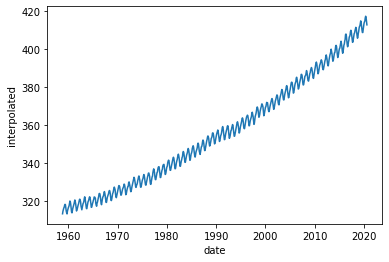

In [12]:
sns.lineplot(x="date", y="interpolated", data=df)

## Define datetime partitioning

Use the snippet below to define datetime partitioning for the data. You can also reference [a more complete example of Datetime Partitioning](https://github.com/datarobot-community/examples-for-data-scientists/blob/master/Advanced%20Tuning%20and%20Partitioning/Python/Datetime%20Partitioning.ipynb).

In [13]:
spec = dr.DatetimePartitioningSpecification(
    datetime_partition_column="date", number_of_backtests=4, use_time_series=False
)

## Start the project
The snippet below passes the `spec` object as an input to the `partitioning_method` variable in the `set_target` method. This starts the project with the designated settings.

In [ ]:
project = dr.Project.create(df, project_name="Predicting CO2 levels for Mauna Loa")

project.set_target("interpolated", partitioning_method=spec, worker_count=-1)
project.wait_for_autopilot()

## Access insights

All model insights are available via the API. The example below displays Feature Impact calculated for one of the trained models.

Access more examples and sample code for extracting insights from [the DataRobot Community]( https://github.com/datarobot-community/examples-for-data-scientists/tree/master/Model%20Evaluation/Python).

In [15]:
model = project.get_models()[0]

# Get Feature Impact
feature_impact = model.get_or_request_feature_impact()

# Save feature impact in pandas dataframe
fi_df = pd.DataFrame(feature_impact)

<AxesSubplot:xlabel='featureName', ylabel='impactNormalized'>

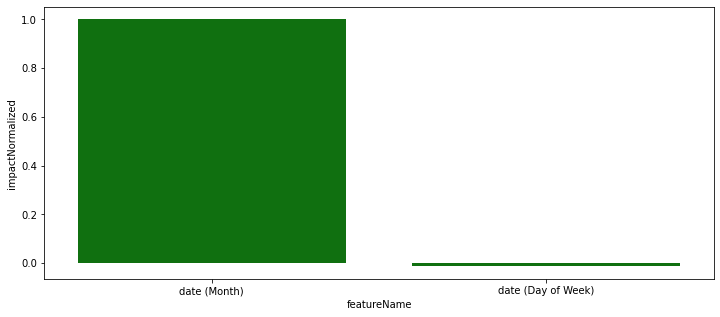

In [16]:
fig, ax = plt.subplots(figsize=(12, 5))

# Plot feature impact
sns.barplot(x="featureName", y="impactNormalized", data=fi_df[0:5], color="g")